# **Exoplanets, Kepler Confirmed Planets and Solar System Planets!**

*Author: Anton Zaitsev*  
*Date: December 7, 2023*

---------

# Data

## NASA Exoplanet Archive

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS

## Solar System Major Bodies Data

https://www.kaggle.com/datasets/jaredsavage/solar-system-major-bodies-data

## Kepler Confirmed Planets

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=kep_conf_names


## Equilibrium Temperatures for Solar Planets

http://astro.vaporia.com/start/equilibriumtemperature.html

## The Distances from the Solar Planets to the Earth

https://promenade.imcce.fr/en/pages5/573.html

## Data Description

### NASA Exoplanet Archive

NASA Exoplanet Archive dataset contains information on confirmed planets outside of the Solar System, e.g. planet mass, radius, planet discovery method, orbital period, etc.

Rows: 35131
Columns: 286

### Solar System Major Bodies Data

The Solar System Planets dataset contains information on major bodies inside the Solar System, including planets, such as Earth, Mars, Venus, etc. It includes information on body's attributes, such as mass, density, etc.

Rows: 31
Columns: 265

### Kepler Confirmed Planets

The Kepler Confirmed Planets dataset includes information about exoplanets that have been confirmed through observations by NASA's Kepler mission. Kepler-confirmed planets are those KOIs that have undergone further scrutiny and have been confirmed as actual exoplanets through additional observations. The confirmation process aims to rule out false positives and confirm that the observed signals are consistent with the presence of planets.

Rows: 2807
Columns: 4

---------



In [16]:
# Imports

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from IPython.display import Image

In [17]:
# Global Variables

EXOPLANETS_PATH = 'data/exoplanets.csv'
EXOPLANETS_HEADER = 290
SOLARPLANETS_URL = 'data/solarplanets.csv'
KEPLER_PATH = 'data/kepler.csv'
KEPLER_HEADER = 8


# Data Engineering

## Exoplanets

In [18]:
## Exoplanets

descriptions = pd.read_csv(EXOPLANETS_PATH, nrows=EXOPLANETS_HEADER - 1)[2:-1].iloc[:, 0].tolist()
column_descriptions = {}
for item in descriptions:
    parts = item.split(':')
    if len(parts) == 2:
        key = parts[0].strip().split()[-1]
        value = parts[1].strip()
        column_descriptions[key] = value

columns_considered = [
    'pl_name', 'hostname', 'disc_year', 'discoverymethod', 
    'pl_controv_flag', 'sy_snum', 'sy_pnum', 'sy_mnum',
    'pl_orbper', 'pl_rade', 'pl_masse', 'pl_dens',
    'pl_orbeccen', 'pl_insol', 'pl_eqt', 'pl_orbincl',
    'st_teff', 'st_rad', 'st_mass', 'st_lum', 
    'st_logg', 'st_age', 'st_dens', 'sy_dist', 'pl_orbsmax',
]
exoplanets_dirty = pd.read_csv(EXOPLANETS_PATH, header=EXOPLANETS_HEADER, usecols=columns_considered, index_col=None)

columns_group = ['pl_name', 'hostname', 'disc_year', 'discoverymethod']
exoplanets = exoplanets_dirty.groupby(columns_group).mean()
exoplanets = exoplanets.reset_index()
exoplanets


,pl_name,hostname,disc_year,discoverymethod,sy_snum,sy_pnum,sy_mnum,pl_controv_flag,pl_orbper,pl_orbsmax,...,pl_eqt,pl_orbincl,st_teff,st_rad,st_mass,st_lum,st_logg,st_age,st_dens,sy_dist
0,11 Com b,11 Com,2007,Radial Velocity,2.0,1.0,0.0,0.0,324.620000,1.226000,...,NaN,NaN,4808.000000,16.380000,2.463333,2.1105,2.3800,NaN,NaN,93.1846
1,11 UMi b,11 UMi,2009,Radial Velocity,1.0,1.0,0.0,0.0,516.219985,1.526667,...,NaN,NaN,4276.500000,26.935000,2.093333,NaN,1.7650,1.560000,NaN,125.3210
2,14 And b,14 And,2008,Radial Velocity,1.0,1.0,0.0,0.0,186.300000,0.761667,...,NaN,NaN,4850.500000,11.275000,1.726667,1.8015,2.5900,NaN,NaN,75.4392
3,14 Her b,14 Her,2002,Radial Velocity,1.0,2.0,0.0,0.0,1766.378417,2.814750,...,NaN,144.652,5296.985000,0.976667,0.927143,-0.1515,4.4200,3.900000,1.2739,17.9323
4,16 Cyg B b,16 Cyg B,1996,Radial Velocity,3.0,1.0,0.0,0.0,799.375000,1.662833,...,NaN,NaN,5728.594000,1.140000,1.016000,0.0970,4.3440,NaN,1.0110,21.1397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5534,ups And b,ups And,1996,Radial Velocity,2.0,3.0,0.0,0.0,4.616229,0.058895,...,NaN,NaN,6137.820000,1.615000,1.250000,0.5250,4.1625,3.706667,0.3699,13.4054
5535,ups And c,ups And,1999,Radial Velocity,2.0,3.0,0.0,0.0,240.728533,0.827712,...,NaN,NaN,6117.093333,1.615000,1.262500,0.5250,4.1500,4.060000,0.3699,13.4054
5536,ups And d,ups And,1999,Radial Velocity,2.0,3.0,0.0,0.0,1285.346167,2.528382,...,NaN,NaN,6117.093333,1.615000,1.262500,0.5250,4.1500,4.060000,0.3699,13.4054
5537,ups Leo b,ups Leo,2021,Radial Velocity,1.0,1.0,0.0,0.0,385.200000,1.180000,...,NaN,NaN,4836.000000,11.220000,1.480000,1.8000,2.4600,NaN,NaN,52.5973


### Solar Planets

In [19]:
solar_bodies = pd.read_csv(SOLARPLANETS_URL)
solarplanets_names = ['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']
solarplanets = solar_bodies[solar_bodies['eName'].isin(solarplanets_names)].reset_index()
solarplanets['pl_eqt'] = [64, 51, 122, 226, 449, 90, 279, 328]
au_parcec = 206265
solarplanets['earth_dist_avg'] = [
    (17.292 + 21.089)/au_parcec,
    (28.817 + 31.317)/au_parcec,
    (3.957 + 6.454)/au_parcec,
    (0.372 + 2.671)/au_parcec,
    (0.552 + 1.446)/au_parcec,
    (8.050 + 11.046)/au_parcec,
    0/au_parcec,
    (0.266 + 1.736)/au_parcec
]
solarplanets


,index,eName,isPlanet,semimajorAxis,perihelion,aphelion,eccentricity,inclination,density,gravity,...,geomAlbido,RV_abs,p_transit,transit_visibility,transit_depth,massj,semimajorAxis_AU,grav_int,pl_eqt,earth_dist_avg
0,199,Uranus,True,2870658186,2147483647,2147483647,0.0457,0.772,1.2700,8.87,...,0.488,0.296744,0.000251,0.045253,0.001327,0.045684,19.189165,1.398930e+21,64,0.000186
1,219,Neptune,True,4498396441,2147483647,2147483647,0.0113,1.769,1.6380,11.15,...,0.442,0.278582,0.000160,0.028849,0.001250,0.053684,30.069923,6.694590e+20,51,0.000292
2,238,Jupiter,True,778340821,740379835,816620000,0.0489,1.304,1.3262,24.79,...,0.538,12.473518,0.000984,0.177205,0.010080,1.000000,5.202887,4.165367e+23,122,0.000050
3,239,Mars,True,227943824,206700000,249200000,0.0935,1.850,3.9341,3.71,...,0.170,0.007785,0.003070,0.552556,0.000024,0.000338,1.523710,1.641038e+21,226,0.000015
4,240,Mercury,True,57909227,46001200,69816900,0.2056,7.000,5.4291,3.70,...,0.142,0.007939,0.012067,2.172031,0.000012,0.000174,0.387099,1.306946e+22,449,0.000010
5,241,Saturn,True,1426666422,1349823615,1503509229,0.0565,2.485,0.6871,10.44,...,0.499,2.752346,0.000529,0.095203,0.006993,0.298947,9.536676,3.706318e+22,90,0.000093
6,243,Earth,True,149598262,147095000,152100000,0.0167,0.000,5.5136,9.80,...,0.367,0.089355,0.004697,0.845520,0.000084,0.003142,1.000003,3.542913e+22,279,0.000000
7,244,Venus,True,108208475,107477000,108939000,0.0067,3.390,5.2430,8.87,...,0.689,0.085703,0.006491,1.168401,0.000076,0.002563,0.723329,5.523898e+22,328,0.000010


## Kepler Planets

In [20]:
keplerplanets = pd.read_csv(KEPLER_PATH, header=KEPLER_HEADER, index_col=None)
keplerplanets


,kepid,koi_name,kepler_name,pl_name
0,11446443,K00001.01,Kepler-1 b,TrES-2 b
1,11904151,K00072.01,Kepler-10 b,Kepler-10 b
2,11904151,K00072.02,Kepler-10 c,Kepler-10 c
3,11904151,NaN,Kepler-10 d,Kepler-10 d
4,6521045,K00041.02,Kepler-100 b,Kepler-100 b
...,...,...,...,...
2802,4035640,K01881.01,Kepler-995 b,Kepler-995 b
2803,6205228,K01882.01,Kepler-996 b,Kepler-996 b
2804,11758544,K01883.01,Kepler-997 b,Kepler-997 b
2805,11413812,K01885.01,Kepler-998 b,Kepler-998 b


In [21]:
### Join Exoplanets and Kepler Confirmed Planets

exoplanets = exoplanets.copy() 
exoplanets['kepler_confirmed'] = exoplanets['pl_name'].isin(keplerplanets['pl_name'])
exoplanets['kepler_confirmed'] = exoplanets['kepler_confirmed'].astype(bool)


---------

# Exploratory Analysis

## Number of Exoplanets Discovered by Year and Discovery Method

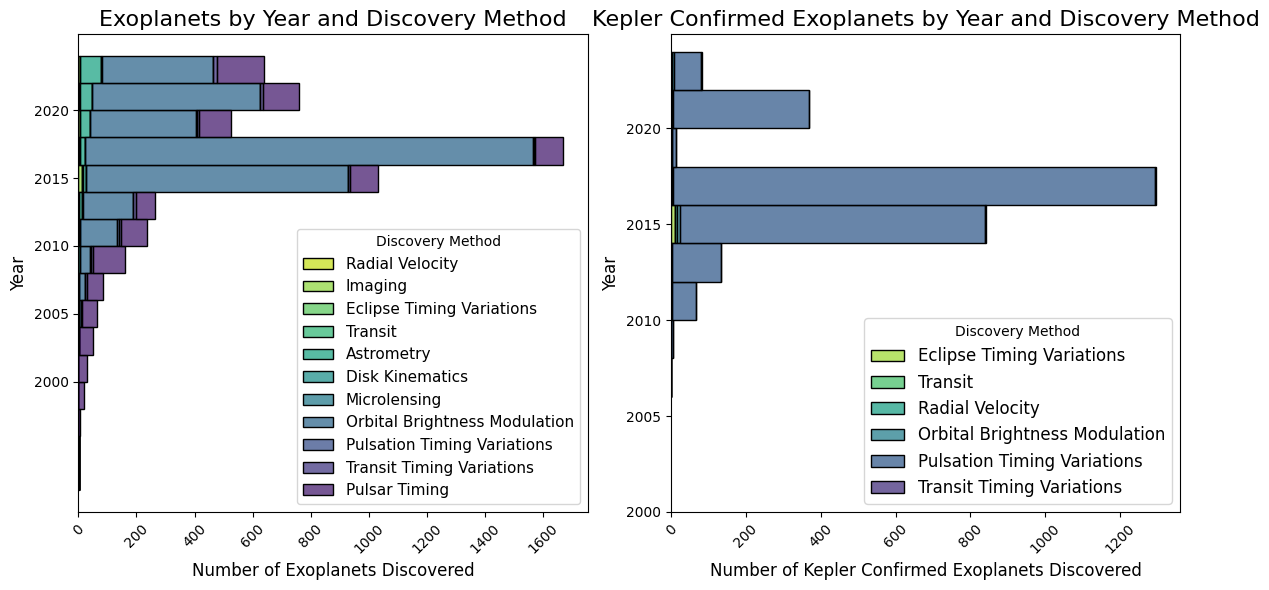

In [22]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 2, 1)
sns.histplot(
    data=exoplanets, 
    y='disc_year', 
    multiple="stack",
    binwidth=2, 
    hue='discoverymethod', 
    palette='viridis'
)
plt.title('Exoplanets by Year and Discovery Method', fontsize=16)
plt.xlabel('Number of Exoplanets Discovered',fontsize=12)
plt.ylabel('Year',fontsize=12)
plt.xticks(rotation=45)
plt.yticks(range(2000, max(exoplanets['disc_year'])+1, 5))
legend_labels = exoplanets['discoverymethod'].unique()
ax1.legend(labels=legend_labels, title='Discovery Method', fontsize=11)

ax2 = plt.subplot(1, 2, 2)
sns.histplot(
    data=exoplanets[exoplanets['kepler_confirmed']], 
    y='disc_year', 
    multiple="stack",
    binwidth=2, 
    hue='discoverymethod', 
    palette='viridis'
)
plt.title('Kepler Confirmed Exoplanets by Year and Discovery Method', fontsize=16)
plt.xlabel('Number of Kepler Confirmed Exoplanets Discovered',fontsize=12)
plt.ylabel('Year',fontsize=12)
plt.xticks(rotation=45)
plt.yticks(range(2000, max(exoplanets['disc_year'])+1, 5))
legend_labels_kepler = exoplanets[exoplanets['kepler_confirmed']]['discoverymethod'].unique()
ax2.legend(labels=legend_labels_kepler, title='Discovery Method', fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()



# Is Exoplanet Controversial?

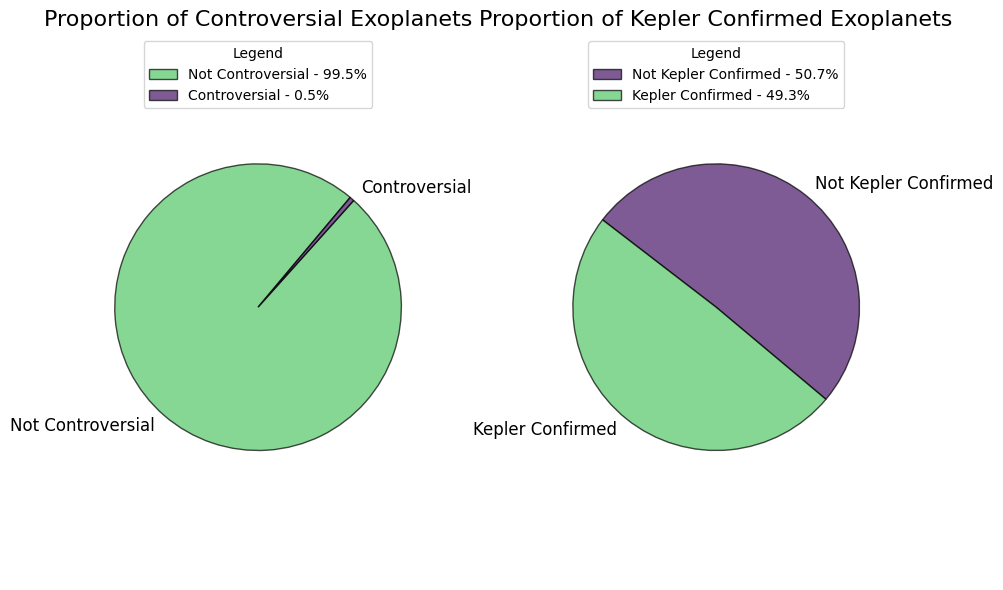

In [23]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
wedges, texts, autotexts = plt.pie(
    exoplanets['pl_controv_flag'].value_counts(), 
    labels=['Not Controversial', 'Controversial'], 
    autopct='', 
    colors=['#55C667FF', '#481567FF'],
    textprops={'fontsize': 12, 'color': 'black'}, 
    wedgeprops={'edgecolor': 'black', "alpha": 0.7},
    startangle=50
)
percs = exoplanets['pl_controv_flag'].value_counts(normalize=True)*100
labels = [f'{label} - {perc:.1f}%' for label, perc in zip(['Not Controversial', 'Controversial'], percs)]
plt.legend(
    wedges, 
    labels, 
    title='Legend', 
    bbox_to_anchor=(0.5, 1),
    loc='upper center'
)
plt.axis('equal')
plt.title('Proportion of Controversial Exoplanets', fontsize=16)

plt.subplot(1, 2, 2)
wedges, texts, autotexts = plt.pie(
    exoplanets['kepler_confirmed'].value_counts(), 
    labels=['Not Kepler Confirmed', 'Kepler Confirmed'], 
    autopct='', 
    colors=['#481567FF', '#55C667FF'],
    textprops={'fontsize': 12, 'color': 'black'}, 
    wedgeprops={'edgecolor': 'black', "alpha": 0.7},
    startangle=320
)
percs = exoplanets['kepler_confirmed'].value_counts(normalize=True)*100
labels = [f'{label} - {perc:.1f}%' for label, perc in zip(['Not Kepler Confirmed', 'Kepler Confirmed'], percs)]
plt.legend(
    wedges, 
    labels, 
    title='Legend', 
    bbox_to_anchor=(0.5, 1),
    loc='upper center'
)
plt.axis('equal')
plt.title('Proportion of Kepler Confirmed Exoplanets', fontsize=16)

plt.tight_layout()
plt.show()


## Orbital Period (Including Earth)

Here, we will explore the relationship between orbital period of a planet to its mass, radius (mean), distance from host planet and eccentricity.

> - Orbital period is the time it takes for a celestial object, such as a planet, to complete one full revolution around its host star or a central point in its orbit.
> - Planetary radius refers to the average distance from the center to the outer boundary of a celestial body, such as a planet, providing a measure of its size.
> - Eccentricity is a measure of how elliptical or circular an orbit is.
>   - An eccentricity of 0 indicates a perfectly circular orbit.
>   - An eccentricity close to 1 indicates a highly elongated or elliptical orbit.
> - An astronomical unit (AU) is a unit of measurement equal to the average distance between a planet and its host star.
>   - 1 AU is the average distance from the Earth to the Sun.
>   - 1 AU = 1.5 x 10^8 KM (150 million kilometers)
>   - 1 Parsec = 206,265 AU
>   - 1 parsec = 3.09 x 10^13 KM
> - Earth radius - 6,371 km

In [24]:
### Work on Solar Planets Data

#### Convert Mass | Radius into Earth Mass

solarplanets = solarplanets.copy()
earth_mass = solarplanets.loc[solarplanets['eName'] == 'Earth', 'mass_kg'].values[0]
solarplanets['mass_earth'] = solarplanets['mass_kg'] / earth_mass
earth_radius = solarplanets.loc[solarplanets['eName'] == 'Earth', 'meanRadius'].values[0]
solarplanets['radius_earth'] = solarplanets['meanRadius'] / earth_radius

earth_data = solarplanets[solarplanets['eName'] == 'Earth']


In [25]:
### Drop Planets with NAs

columns_drop_nas = ['pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_masse', 'pl_orbeccen', 'sy_dist']
exoplanets_nas = exoplanets.dropna(subset=columns_drop_nas)


### Correlation Heatmap

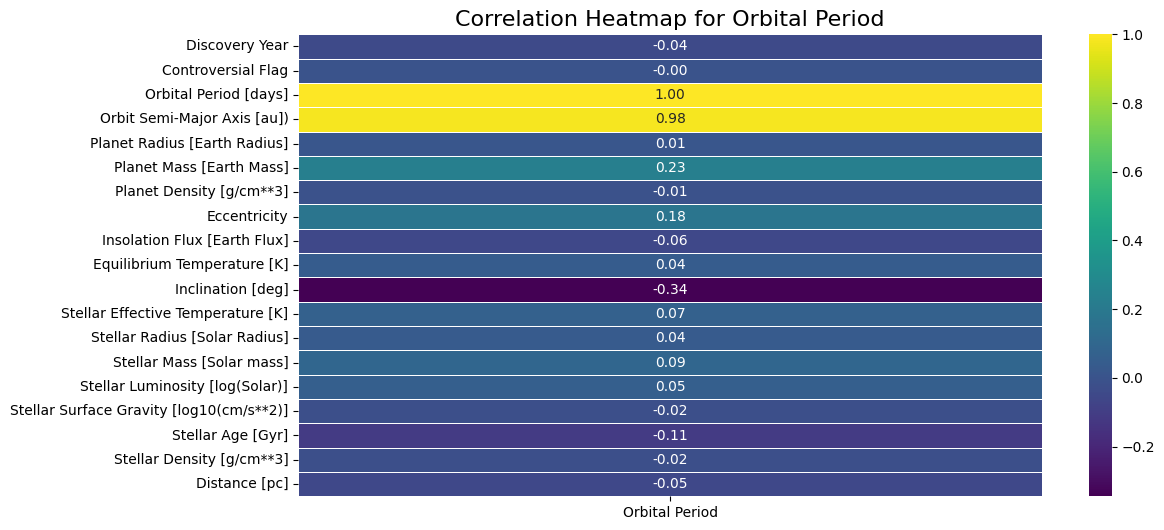

In [26]:
exoplanets_corr = exoplanets_nas.drop(columns=['sy_mnum', 'sy_snum', 'sy_pnum']).select_dtypes(include=['number']).corr()
pl_orbper_corr = exoplanets_corr.loc[['pl_orbper'], :]
column_mapping = {key: column_descriptions.get(key, key) for key in pl_orbper_corr.columns}
pl_orbper_corr_T = exoplanets_corr.loc[['pl_orbper'], :].T

plt.figure(figsize=(12, 6))
ax = sns.heatmap(pl_orbper_corr_T, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5, xticklabels=['Orbital Period'])
plt.title('Correlation Heatmap for Orbital Period', fontsize=16)
ax.set_yticklabels([column_mapping[key] for key in pl_orbper_corr.columns])

plt.show()


### Plot Relationships

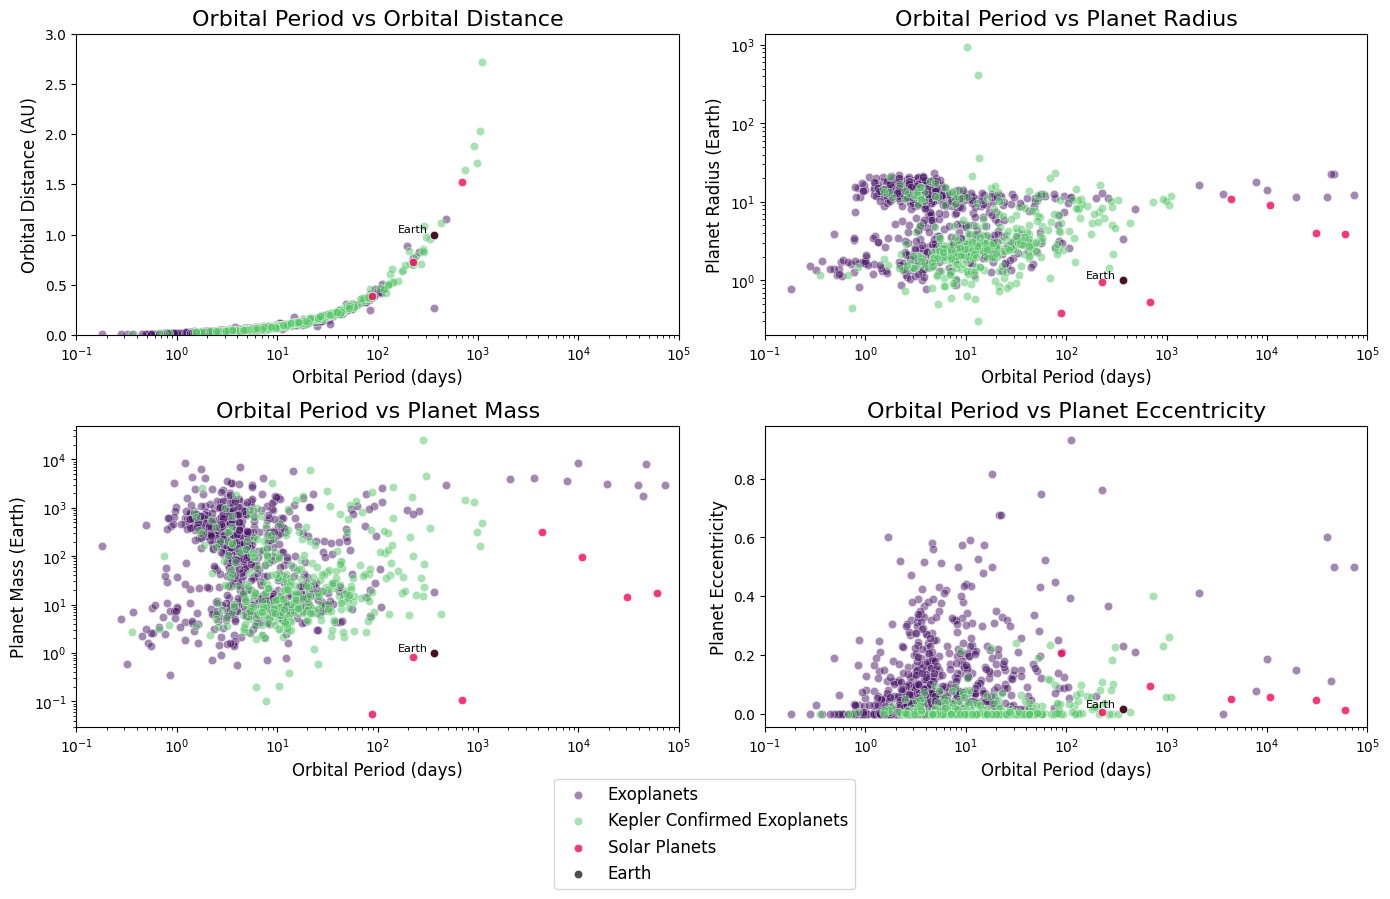

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

# distance
sns.scatterplot(x='pl_orbper', y='pl_orbsmax', data=exoplanets_nas[exoplanets_nas['kepler_confirmed']==False], label='Exoplanets', alpha=0.5, color='#481567FF', ax=axes[0, 0])
sns.scatterplot(x='pl_orbper', y='pl_orbsmax', data=exoplanets_nas[exoplanets_nas['kepler_confirmed']], label='Kepler Confirmed Exoplanets', alpha=0.5, color='#55C667FF', ax=axes[0, 0])
sns.scatterplot(x='sideralOrbit', y='semimajorAxis_AU', data=solarplanets, label='Solar Planets', alpha=0.8, color='#f0055b', ax=axes[0, 0])

sns.scatterplot(x='sideralOrbit', y='semimajorAxis_AU', data=earth_data, label='Earth', alpha=0.7, color='black', ax=axes[0, 0])
earth_x = earth_data['sideralOrbit'].values[0]
earth_y = earth_data['semimajorAxis_AU'].values[0]
axes[0, 0].text(earth_x - 50, earth_y, 'Earth', color='black', fontsize=8, ha='right', va='bottom')

axes[0, 0].set_xscale('log')
axes[0, 0].set_xlim(10**(-1), 10**5)
axes[0, 0].set_ylim(0, 3)
axes[0, 0].set_title('Orbital Period vs Orbital Distance', fontsize=16)
axes[0, 0].set_xlabel('Orbital Period (days)', fontsize=12)
axes[0, 0].set_ylabel('Orbital Distance (AU)', fontsize=12)

# radius 
sns.scatterplot(x='pl_orbper', y='pl_rade', data=exoplanets_nas[exoplanets_nas['kepler_confirmed']==False], label='Exoplanets', alpha=0.5, color='#481567FF', ax=axes[0, 1])
sns.scatterplot(x='pl_orbper', y='pl_rade', data=exoplanets_nas[exoplanets_nas['kepler_confirmed']], label='Kepler Confirmed Exoplanets', alpha=0.5, color='#55C667FF', ax=axes[0, 1])
sns.scatterplot(x='sideralOrbit', y='radius_earth', data=solarplanets, label='Solar Planets', alpha=0.8, color='#f0055b', ax=axes[0, 1])

sns.scatterplot(x='sideralOrbit', y='radius_earth', data=earth_data, label='Earth', alpha=0.7, color='black', ax=axes[0, 1])
earth_x = earth_data['sideralOrbit'].values[0]
earth_y = earth_data['radius_earth'].values[0]
axes[0, 1].text(earth_x - 50, earth_y, 'Earth', color='black', fontsize=8, ha='right', va='bottom')

axes[0, 1].set_xscale('log')
axes[0, 1].set_xlim(10**(-1), 10**5)
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlabel('Orbital Period (days)', fontsize=12)
axes[0, 1].set_ylabel('Planet Radius (Earth)', fontsize=12)
axes[0, 1].set_title('Orbital Period vs Planet Radius', fontsize=16)

# mass
sns.scatterplot(x='pl_orbper', y='pl_masse', data=exoplanets_nas[exoplanets_nas['kepler_confirmed']==False], label='Exoplanets', alpha=0.5, color='#481567FF', ax=axes[1, 0])
sns.scatterplot(x='pl_orbper', y='pl_masse', data=exoplanets_nas[exoplanets_nas['kepler_confirmed']], label='Kepler Confirmed Exoplanets', alpha=0.5, color='#55C667FF', ax=axes[1, 0])
sns.scatterplot(x='sideralOrbit', y='mass_earth', data=solarplanets, label='Solar Planets', alpha=0.8, color='#f0055b', ax=axes[1, 0])

sns.scatterplot(x='sideralOrbit', y='mass_earth', data=earth_data, label='Earth', alpha=0.7, color='black', ax=axes[1, 0])
earth_x = earth_data['sideralOrbit'].values[0]
earth_y = earth_data['mass_earth'].values[0]
axes[1, 0].text(earth_x - 50, earth_y, 'Earth', color='black', fontsize=8, ha='right', va='bottom')

axes[1, 0].set_xscale('log')
axes[1, 0].set_xlim(10**(-1), 10**5)
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel('Orbital Period (days)', fontsize=12)
axes[1, 0].set_ylabel('Planet Mass (Earth)', fontsize=12)
axes[1, 0].set_title('Orbital Period vs Planet Mass', fontsize=16)

# eccentricity
sns.scatterplot(x='pl_orbper', y='pl_orbeccen', data=exoplanets_nas[exoplanets_nas['kepler_confirmed']==False], label='Exoplanets', alpha=0.5, color='#481567FF', ax=axes[1, 1])
sns.scatterplot(x='pl_orbper', y='pl_orbeccen', data=exoplanets_nas[exoplanets_nas['kepler_confirmed']], label='Kepler Confirmed Exoplanets', alpha=0.5, color='#55C667FF', ax=axes[1, 1])
sns.scatterplot(x='sideralOrbit', y='eccentricity', data=solarplanets, label='Solar Planets', alpha=0.8, color='#f0055b', ax=axes[1, 1])

sns.scatterplot(x='sideralOrbit', y='eccentricity', data=earth_data, label='Earth', alpha=0.7, color='black', ax=axes[1, 1])
earth_x = earth_data['sideralOrbit'].values[0]
earth_y = earth_data['eccentricity'].values[0]
axes[1, 1].text(earth_x - 50, earth_y, 'Earth', color='black', fontsize=8, ha='right', va='bottom')

axes[1, 1].set_xscale('log')
axes[1, 1].set_xlim(10**(-1), 10**5)
axes[1, 1].set_xlabel('Orbital Period (days)', fontsize=12)
axes[1, 1].set_ylabel('Planet Eccentricity', fontsize=12)
axes[1, 1].set_title('Orbital Period vs Planet Eccentricity', fontsize=16)

for ax in axes.flat:
    ax.get_legend().remove()
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.62, 0.03), fontsize=12)
plt.tight_layout()
plt.show()


### Why?
> Kepler's Third Law: the squares of the orbital periods of the planets are directly proportional to the cubes of the semi-major axes of their orbits. Kepler's Third Law implies that the period for a planet to orbit the Sun increases rapidly with the radius of its orbit (distance increases $=>$ orbital period increases)

# Orbital Period - Animation

## Data

In [28]:
## Combine Kepler Planets with Solar Planets
# <sub>Column Renaming, Concatenation</sub>

exoplanets_kepler = exoplanets_nas[exoplanets_nas['kepler_confirmed']]
exoplanets_cols= ['pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_eqt', 'pl_name', 'sy_dist']
exoplanets_kepler_animation = exoplanets_kepler[exoplanets_cols]

solarplanets_cols = ['sideralOrbit', 'semimajorAxis_AU', 'radius_earth', 'pl_eqt', 'eName', 'earth_dist_avg']
solarplanets_animation = solarplanets[solarplanets['eName'] != 'Earth']
solarplanets_animation = solarplanets_animation[solarplanets_cols]
earth_animation = earth_data[solarplanets_cols]

solarplanets_rename_cols = {'sideralOrbit': 'pl_orbper', 'semimajorAxis_AU': 'pl_orbsmax', 'radius_earth': 'pl_rade', 'pl_eqt': 'pl_eqt', 'eName': 'pl_name', 'earth_dist_avg': 'sy_dist'}
solarplanets_animation = solarplanets_animation.copy()
solarplanets_animation.rename(columns=solarplanets_rename_cols, inplace=True)
earth_animation = earth_animation.copy()
earth_animation.rename(columns=solarplanets_rename_cols, inplace=True)

solar_exo_animation = pd.concat([exoplanets_kepler_animation, solarplanets_animation, earth_animation], ignore_index=True)

solar_exo_animation


,pl_orbper,pl_orbsmax,pl_rade,pl_eqt,pl_name,sy_dist
0,4.887805,0.052766,4.743417,815.125000,HAT-P-11 b,37.764700
1,2.204736,0.037185,16.671200,2237.900000,HAT-P-7 b,341.079000
2,17.855217,0.148143,14.993545,931.166667,KOI-12 b,399.398000
3,1.763594,0.037601,20.732462,3202.222222,KOI-13 b,519.096000
4,10.926917,0.098000,3.780167,769.000000,KOI-142 b,376.863000
...,...,...,...,...,...,...
360,686.980000,1.523710,0.532019,226.000000,Mars,0.000015
361,87.969000,0.387099,0.382891,449.000000,Mercury,0.000010
362,10759.220000,9.536676,9.140154,90.000000,Saturn,0.000093
363,224.701000,0.723329,0.949897,328.000000,Venus,0.000010


In [40]:
## Define Data for Plots
### Prepare Data

num_planets = len(solar_exo_animation)
num_frames = 3400
starting_distance = 2.5

angles = np.zeros((num_frames, num_planets))
x_positions = np.zeros((num_frames, num_planets))
y_positions = np.zeros((num_frames, num_planets))
planet_sizes = np.zeros((num_frames, num_planets))

for i in range(num_frames):
    for j in range(num_planets):
        angle = np.pi * i / (4 * solar_exo_animation['pl_orbper'].iloc[j])
        x_position = (solar_exo_animation['pl_orbsmax'].iloc[j] + starting_distance) * np.sin(angle)
        y_position = (solar_exo_animation['pl_orbsmax'].iloc[j] + starting_distance) * np.cos(angle)
        
        angles[i][j] = angle
        x_positions[i][j] = x_position
        y_positions[i][j] = y_position
        planet_sizes[i][j] = solar_exo_animation['pl_rade'].iloc[j]

data_regplot1 = solar_exo_animation[
    (solar_exo_animation['pl_orbsmax'] >= 0) & (solar_exo_animation['pl_orbsmax'] <= 1.4) &
    (solar_exo_animation['pl_orbper'] >= 0) & (solar_exo_animation['pl_orbper'] <= 500)
][['pl_orbsmax', 'pl_orbper']]

data_regplot2 = solar_exo_animation[
    (solar_exo_animation['pl_orbsmax'] >= 0) & (solar_exo_animation['pl_orbsmax'] <= 0.2) &
    (solar_exo_animation['pl_orbper'] >= 0) & (solar_exo_animation['pl_orbper'] <= 40)
][['pl_orbsmax', 'pl_orbper']]


In [ ]:
fig = plt.figure(figsize=(16, 8))
gridspan = fig.add_gridspec(2, 2)
fig.suptitle("Distance from Star, Orbital Period and Planet's Temperature", fontsize=16)
 
ax1 = fig.add_subplot(gridspan[0, :])
ax2 = fig.add_subplot(gridspan[1, 0])
ax3 = fig.add_subplot(gridspan[1, 1])

ax1.set_xlim(-4, 4)
ax1.set_ylim(-12, 12)
ax1.set_xlabel('Distance from Star (AU)', fontsize=12)
ax1.set_ylabel('Distance from Star (AU)', fontsize=12)

norm = Normalize(vmin=solar_exo_animation['pl_eqt'].min(), vmax=solar_exo_animation['pl_eqt'].max())

k_p = ax1.scatter(x=[], y=[], s=[], c=[], cmap='viridis', alpha=0.8, norm=norm)
s_p = ax1.scatter(x=[], y=[], s=[], c=[], cmap='viridis', norm=norm)
earth = ax1.scatter(x=[], y=[], s=50, c=[], cmap='viridis', norm=norm)
earth_text = ax1.text(0, 0, 'Earth', color='black', ha='right', va='bottom')
ax1.scatter(x=0, y=0, s=1500, color="#f5a462", edgecolors='black', alpha=0.5)

cbar_kp = plt.colorbar(k_p, ax=ax1)
cbar_kp.set_label('Temperature (K)', rotation=270, labelpad=15)

def update(i):
    k_p.set_offsets(np.column_stack((x_positions[i % num_frames, :len(solar_exo_animation) - 8],
                                    y_positions[i % num_frames, :len(solar_exo_animation) - 8])))
    k_p.set_sizes(planet_sizes[i % num_frames, :len(solar_exo_animation) - 8])
    k_p.set_array(solar_exo_animation['pl_eqt'].iloc[:len(solar_exo_animation) - 8])

    s_p.set_offsets(np.column_stack((x_positions[i % num_frames, -8:-1],
                                    y_positions[i % num_frames, -8:-1])))
    s_p.set_sizes(planet_sizes[i % num_frames, -8:-1])
    s_p.set_array(solar_exo_animation['pl_eqt'].iloc[-8:-1])

    earth.set_offsets(np.column_stack((x_positions[i % num_frames, -1],
                                    y_positions[i % num_frames, -1])))
    earth.set_array([solar_exo_animation['pl_eqt'].iloc[-1]])

    earth_text.set_position((x_positions[i % num_frames, -1], y_positions[i % num_frames, -1]))

    return k_p, s_p, earth, earth_text

ax2.set_xlim(0, 1.2)
ax2.set_ylim(0, 500)

scatter = ax2.scatter(x=solar_exo_animation['pl_orbsmax'], 
                         y=solar_exo_animation['pl_orbper'], 
                         c=solar_exo_animation['pl_eqt'],
                         s=solar_exo_animation['pl_rade']*3, 
                         cmap='viridis', 
                         alpha=0.6)
sns.regplot(
    x=data_regplot1['pl_orbsmax'], 
    y=data_regplot1['pl_orbper'],
    scatter=False,
    ax=ax2,
    color='#0a456e',
    ci=None, 
    truncate=True,
    scatter_kws={'alpha':0.8}
)

ax2.annotate('Earth', 
             xy=(earth_animation['pl_orbsmax'], earth_animation['pl_orbper']),
             xytext=(5, 5),
             textcoords='offset points',
             ha='right',
             va='bottom',
             fontsize=8,
             color='black')


ax2.set_xlabel('Distance from Star (AU)', fontsize=12)
ax2.set_ylabel('Orbital Period (Days)', fontsize=12)
ax2.set_title('How Distance and Orbital Period relate to Temperature', fontsize=12)

ax3.set_xlim(0, 0.2)
ax3.set_ylim(0, 40)

scatter = ax3.scatter(x=solar_exo_animation['pl_orbsmax'], 
                         y=solar_exo_animation['pl_orbper'], 
                         c=solar_exo_animation['pl_eqt'],
                         s=solar_exo_animation['pl_rade']*3, 
                         cmap='viridis', 
                         alpha=0.6)
sns.regplot(
    x=data_regplot2['pl_orbsmax'], 
    y=data_regplot2['pl_orbper'],
    scatter=False,
    ax=ax3,
    color='#0a456e',
    ci=None, 
    truncate=True,
    scatter_kws={'alpha':0.8}
)


ax3.set_xlabel('Distance from Star (AU)', fontsize=12)
ax3.set_ylabel('Orbital Period (Days)', fontsize=12)
ax3.set_title('How Distance and Orbital Period relate to Temperature (Closer Look)', fontsize=12)

plt.tight_layout()

ani = FuncAnimation(fig, update, frames=num_frames, blit=True, interval=200, repeat=False)
ani.save('data/planets_orbiting_star_animation.gif', writer='pillow', fps=30)

# Image(filename='planets_orbiting_star_animation.gif')
# plt.show()

![Alt Text](data/planets_orbiting_star_animation.gif)

# Some Maximums

In [230]:
column_averages = solar_exo_animation.drop(columns=['pl_name']).mean()
table1 = solar_exo_animation.nlargest(10, 'pl_orbper')[['pl_name', 'pl_orbper']].round(2)
table2 = solar_exo_animation.nlargest(10, 'pl_orbsmax')[['pl_name', 'pl_orbsmax']].round(2)
table3 = solar_exo_animation.nlargest(10, 'pl_rade')[['pl_name', 'pl_rade']].round(2)
table4 = solar_exo_animation.nlargest(10, 'pl_eqt')[['pl_name', 'pl_eqt']].round(2)
table5 = solar_exo_animation.nlargest(10, 'sy_dist')[['pl_name', 'sy_dist']].round(2)

<div style="display: flex; justify-content: space-between;">
<!-- Top 10 Orbital Period (Days) -->
<div style="flex: 1">
  <strong>    Top 10 Orbital Period (Days)</strong>
  <table>
    <thead>
      <tr>
        <th>pl_name</th>
        <th>pl_orbper</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>Neptune</td>
        <td>60189.0</td>
      </tr>
      <tr>
        <td>Uranus</td>
        <td>30685.4</td>
      </tr>
      <tr>
        <td>Saturn</td>
        <td>10759.22</td>
      </tr>
      <tr>
        <td>Jupiter</td>
        <td>4332.59</td>
      </tr>
      <tr>
        <td>Kepler-1647 b</td>
        <td>1107.59</td>
      </tr>
      <tr>
        <td>Kepler-1654 b</td>
        <td>1047.84</td>
      </tr>
      <tr>
        <td>Kepler-167 e</td>
        <td>979.95</td>
      </tr>
      <tr>
        <td>Kepler-1704 b</td>
        <td>911.1</td>
      </tr>
      <tr>
        <td>Kepler-1708 b</td>
        <td>737.11</td>
      </tr>
      <tr>
        <td>Mars</td>
        <td>686.98</td>
      </tr>
    </tbody>
  </table>
  <strong>    Average: 339.79</strong>
</div>

<!-- Top 10 Distance from Star (AU) -->
<div style="flex: 1">
  <strong>    Top 10 Distance from Star (AU)</strong>
  <table>
    <thead>
      <tr>
        <th>pl_name</th>
        <th>pl_orbsmax</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>Neptune</td>
        <td>30.07</td>
      </tr>
      <tr>
        <td>Uranus</td>
        <td>19.19</td>
      </tr>
      <tr>
        <td>Saturn</td>
        <td>9.54</td>
      </tr>
      <tr>
        <td>Jupiter</td>
        <td>5.2</td>
      </tr>
      <tr>
        <td>Kepler-1647 b</td>
        <td>2.72</td>
      </tr>
      <tr>
        <td>Kepler-1654 b</td>
        <td>2.03</td>
      </tr>
      <tr>
        <td>Kepler-1704 b</td>
        <td>1.88</td>
      </tr>
      <tr>
        <td>Kepler-167 e</td>
        <td>1.71</td>
      </tr>
      <tr>
        <td>Kepler-1708 b</td>
        <td>1.64</td>
      </tr>
      <tr>
        <td>Mars</td>
        <td>1.52</td>
      </tr>
    </tbody>
  </table>
  <strong>    Average: 0.38</strong>
</div>

<!-- Top 10 Planet Radius (Earth) -->
<div style="flex: 1">
  <strong>    Top 10 Planet Radius (Earth)</strong>
  <table>
    <thead>
      <tr>
        <th>pl_name</th>
        <th>pl_rade</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>Kepler-29 b</td>
        <td>929.99</td>
      </tr>
      <tr>
        <td>Kepler-29 c</td>
        <td>410.69</td>
      </tr>
      <tr>
        <td>KOI-1599.02</td>
        <td>36.37</td>
      </tr>
      <tr>
        <td>Kepler-359 d</td>
        <td>23.46</td>
      </tr>
      <tr>
        <td>Kepler-57 c</td>
        <td>21.52</td>
      </tr>
      <tr>
        <td>KOI-13 b</td>
        <td>20.73</td>
      </tr>
      <tr>
        <td>Kepler-419 b</td>
        <td>20.11</td>
      </tr>
      <tr>
        <td>Kepler-12 b</td>
        <td>18.68</td>
      </tr>
      <tr>
        <td>Kepler-7 b</td>
        <td>17.52</td>
      </tr>
      <tr>
        <td>HAT-P-7 b</td>
        <td>16.67</td>
      </tr>
    </tbody>
  </table>
  <strong>    Average: 8.35</strong>
</div>

<!-- Top 10 Planet Temperature (K) -->
<div style="flex: 1">
  <strong>    Top 10 Planet Temperature (K)</strong>
  <table>
    <thead>
      <tr>
        <th>pl_name</th>
        <th>pl_eqt</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>KOI-13 b</td>
        <td>3202.22</td>
      </tr>
      <tr>
        <td>HAT-P-7 b</td>
        <td>2237.9</td>
      </tr>
      <tr>
        <td>Kepler-78 b</td>
        <td>2236.5</td>
      </tr>
      <tr>
        <td>Kepler-1658 b</td>
        <td>2061.5</td>
      </tr>
      <tr>
        <td>Kepler-407 b</td>
        <td>2037.6</td>
      </tr>
      <tr>
        <td>Kepler-10 b</td>
        <td>2023.09</td>
      </tr>
      <tr>
        <td>Kepler-76 b</td>
        <td>2012.29</td>
      </tr>
      <tr>
        <td>Kepler-21 b</td>
        <td>1874.75</td>
      </tr>
      <tr>
        <td>Kepler-91 b</td>
        <td>1863.5</td>
      </tr>
      <tr>
        <td>Kepler-323 b</td>
        <td>1860.0</td>
      </tr>
    </tbody>
  </table>
  <strong>    Average: 802.80</strong>
</div>

<!-- Top 10 Distance from Earth (Parsec) -->
<div style="flex: 1;">
  <strong>    Top 10 Distance from Earth (Parsec)</strong>
  <table>
    <thead>
      <tr>
        <th>pl_name</th>
        <th>sy_dist</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>Kepler-40 b</td>
        <td>2305.01</td>
      </tr>
      <tr>
        <td>Kepler-328 b</td>
        <td>2213.19</td>
      </tr>
      <tr>
        <td>Kepler-328 c</td>
        <td>2213.19</td>
      </tr>
      <tr>
        <td>Kepler-433 b</td>
        <td>1878.31</td>
      </tr>
      <tr>
        <td>Kepler-223 b</td>
        <td>1859.71</td>
      </tr>
      <tr>
        <td>Kepler-223 c</td>
        <td>1859.71</td>
      </tr>
      <tr>
        <td>Kepler-223 d</td>
        <td>1859.71</td>
      </tr>
      <tr>
        <td>Kepler-223 e</td>
        <td>1859.71</td>
      </tr>
      <tr>
        <td>Kepler-35 b</td>
        <td>1819.17</td>
      </tr>
      <tr>
        <td>Kepler-34 b</td>
        <td>1800.82</td>
      </tr>
    </tbody>
  </table>
  <strong>    Average: 658.63</strong>
</div>

# What's Next?

#### Find planets that have similar statistics to the ones of the Earth and see how far these planets are from the Earth.
#### In other words, find planets that might be suitable for humans!